In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 데이터 불러오기

import pandas as pd
import numpy as np
from tqdm import tqdm, trange

data = pd.read_csv('/content/drive/MyDrive/2021-2 Text mining/ner_merge_data.csv', encoding='utf-16')
# 10.26. 새로 추가한 코드 - Nan 있는 행을 삭제하고 Index도 리셋시킴
data = data.dropna(axis=0)
data = data.reset_index(drop=True)
data = data.drop(['Unnamed: 0'], axis=1)

print("문장의 갯수: ", len(data))


# 데이터에서 모든 문장별로 단어부분과 개체명 태깅정보를 분리하여 저장

sentences, labels = [], []

for i in range(len(data['text'])):
    a = data['text'].loc[i].split()
    sentences.append(a)

for i in range(len(data['label'])):
    b = data['label'].loc[i].split()
    labels.append(b)


문장의 갯수:  1237


In [6]:
# 개체명 단어 리스트

word_labels_list = []

for i in range(len(data['label'])):
    b = data['label'].loc[i].split()
    word_labels_list.append(b)

word_labels_flat = [item for sublist in word_labels_list for item in sublist]


# 개체명 종류 확인

tag_values = list(set(word_labels_flat))
tag_values.append("PAD")
tag2idx = {t: i for i, t in enumerate(tag_values)}
tag2idx

# labels_to_ids = {k: v for v, k in enumerate(set(word_labels_flat))}
# ids_to_labels = {v: k for v, k in enumerate(set(word_labels_flat))}
# labels_to_ids

{'DAMAGE': 3, 'ELEMENT': 1, 'FACTOR': 0, 'None': 2, 'PAD': 4}

In [7]:
# 최대 문장 길이와 batch size 설정

MAX_LEN = 128
bs = 20

In [10]:
# torch, GPU 세팅

!pip install torch
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla K80'

In [9]:
# kobert-transformers install

!pip install kobert-transformers

     |████████████████████████████████| 1.2 MB 5.1 MB/s 
     |████████████████████████████████| 3.4 MB 41.6 MB/s 
     |████████████████████████████████| 3.3 MB 38.8 MB/s 
     |████████████████████████████████| 895 kB 43.1 MB/s 
     |████████████████████████████████| 596 kB 46.6 MB/s 
     |████████████████████████████████| 61 kB 507 kB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [18]:
# 토크나이저 가져오기

from kobert_transformers import get_tokenizer
tokenizer = get_tokenizer()


# 토크나이즈가 잘 되는지 확인하기

t1 =  tokenizer.tokenize("[CLS] 한국어 모델을 공유합니다. [SEP]")
print(t1)

i1 = tokenizer.convert_tokens_to_ids(['[CLS]', '▁한국', '어', '▁모델', '을', '▁공유', '합니다', '.', '[SEP]'])
print(i1)


s1 = '상류측은 1차로의 자동차 전용도로로 2008년도에 기존 아스팔트 포장을 제거하고 LMC를 이용한 전면적인 재표장이 실시된 상태이며 자전거 및 보행자 전용도로인 하류측 교면포장은 아스팔트로 포장되어 있다.'
s2 = '안녕하세요 저는 김학순입니다!' # 예시문장
tokens = tokenizer.tokenize(s1)
print(tokens)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'KoBertTokenizer'.


['[CLS]', '▁한국', '어', '▁모델', '을', '▁공유', '합니다', '.', '[SEP]']
[2, 4958, 6855, 2046, 7088, 1050, 7843, 54, 3]
['▁상', '류', '측은', '▁1', '차', '로', '의', '▁자동차', '▁전용', '도로', '로', '▁2008', '년', '도', '에', '▁기존', '▁아', '스', '팔', '트', '▁포', '장을', '▁제거', '하고', '▁L', 'MC', '를', '▁이용한', '▁전면', '적인', '▁재', '표', '장이', '▁실시', '된', '▁상태', '이며', '▁자전거', '▁및', '▁보', '행', '자', '▁전용', '도로', '인', '▁하', '류', '측', '▁교', '면', '포', '장은', '▁아', '스', '팔', '트로', '▁포', '장', '되어', '▁있다', '.']


In [19]:
# 데이터의 text와 label에 대해 tokenize 수행

def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels

tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(sentences, labels)
]

tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]

In [20]:
# BERT에 사용되기에 앞서 데이터 전처리 수행

from keras.preprocessing.sequence import pad_sequences

input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]

In [22]:
# Train, Test 데이터 셋 나누기

from sklearn.model_selection import train_test_split

tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags,
                                                            random_state=2018, test_size=0.1)
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)


from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)



In [23]:
# BERT 모델 불러오기 (kobert pretrained 모델)

from transformers import BertModel, DistilBertModel, BertForTokenClassification

model = BertForTokenClassification.from_pretrained('skt/kobert-base-v1',
                                       num_labels=len(tag2idx),
                                       output_attentions = False,
                                       output_hidden_states = False)


Downloading:   0%|          | 0.00/535 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/352M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at skt/kobert-base-v1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
model.cuda();

In [26]:
# Finetuning, Optimizer, Scheduler 설정

import transformers
from transformers import BertForTokenClassification, AdamW

FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=5e-5,
    eps=1e-8
)


from transformers import get_linear_schedule_with_warmup

epochs = 4
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)


In [27]:
!pip install seqeval
from seqeval.metrics import f1_score, accuracy_score

     |████████████████████████████████| 43 kB 776 kB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16181 sha256=b2c35d5a06a76b9fe15ef428f56cbccb32b69b00545641f4617823982d6195c7
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval


In [28]:
# Train과 Validation 수행

## Store the average loss after each epoch so we can plot them.
loss_values, validation_loss_values = [], []

for _ in trange(epochs, desc="Epoch"):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.

    # Put the model into training mode.
    model.train()
    # Reset the total loss for this epoch.
    total_loss = 0

    # Training loop
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()
        # forward pass
        # This will return the loss (rather than the model output)
        # because we have provided the `labels`.
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        # get the loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # track train loss
        total_loss += loss.item()
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # Put the model into evaluation mode
    model.eval()
    # Reset the validation loss for this epoch.
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    valid_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]
    
    print("Validation Accuracy: {}".format(accuracy_score(pred_tags, valid_tags)))
    print("Validation F1-Score: {}".format(f1_score([pred_tags], [valid_tags])))
    print()


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Average train loss: 0.5323676485568285


/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: None seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: ELEMENT seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: DAMAGE seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: FACTOR seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
Epoch:  25%|██▌       | 1/4 [00:52<02:36, 52.22s/it]

Validation loss: 0.2951794500861849
Validation Accuracy: 0.8933022505155563
Validation F1-Score: 0.691948658109685

Average train loss: 0.25169587614280836


Epoch:  50%|█████     | 2/4 [01:45<01:45, 52.58s/it]

Validation loss: 0.2886568031140736
Validation Accuracy: 0.8958127857975433
Validation F1-Score: 0.7137223974763407

Average train loss: 0.1955823086734329


Epoch:  75%|███████▌  | 3/4 [02:38<00:52, 52.91s/it]

Validation loss: 0.26936522339071545
Validation Accuracy: 0.9029857437460773
Validation F1-Score: 0.7329317269076306

Average train loss: 0.1616795023104974


Epoch: 100%|██████████| 4/4 [03:29<00:00, 52.45s/it]

Validation loss: 0.2665665383849825
Validation Accuracy: 0.9079171523356945
Validation F1-Score: 0.7467257707032037



In [29]:
# Classification Report

tag_values.sort()

if 'PAD' in tag_values:
    tag_values.remove('PAD')

if 'None' in tag_values:
    tag_values.remove('None')

from sklearn.metrics import classification_report
print(classification_report(pred_tags, valid_tags, labels = tag_values))

              precision    recall  f1-score   support

      FACTOR       0.86      0.79      0.83       785
     ELEMENT       0.87      0.74      0.80      1499
      DAMAGE       0.84      0.85      0.84      1341

   micro avg       0.86      0.79      0.82      3625
   macro avg       0.86      0.79      0.82      3625
weighted avg       0.86      0.79      0.82      3625



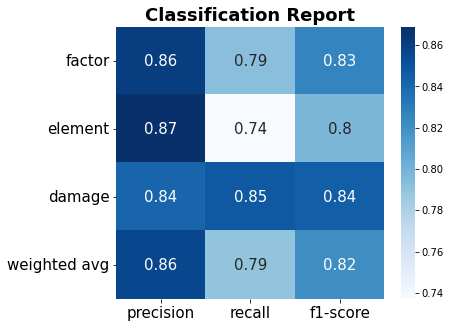

In [32]:
# Classification Report 시각화

tag_values_l = [x.lower() for x in tag_values]
pred_tags_l = [x.lower() for x in pred_tags]
valid_tags_l = [x.lower() for x in valid_tags]

import matplotlib.pyplot as plt
import seaborn as sns

report = classification_report(pred_tags_l, valid_tags_l, labels = tag_values_l, output_dict=True)

plt.figure(figsize = (6,5))
sns.heatmap(pd.DataFrame(report).iloc[:-1, [0, 1, 2, 5]].T, annot=True, cmap='Blues', annot_kws={"size": 15})
plt.yticks(rotation=0, fontsize=15)
plt.xticks(rotation=0, fontsize=15)
plt.title('Classification Report', weight='bold').set_fontsize('18')
plt.show()

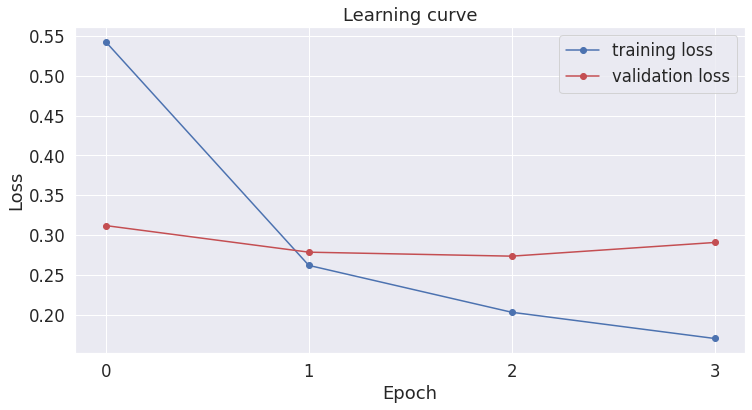

In [ ]:
# Learning Curve 확인

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.xticks(np.arange(0, 4, step=1))  # Set label locations.

plt.show()
